Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

# displaying sample images with a mask

In [ ]:
import retinoto_py as fovea
N_show = 6
args = fovea.Params(batch_size=N_show)
args

Running on MPS device (Apple Silicon/MacOS) - macos_version = 26.1
Random seed 1998 has been set.
Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	User laurentperrinet Working on host obiwan.local with device mps, pytorch==2.9.1


Params(image_size=224, num_epochs=5, n_train_stop=0, seed=1998, batch_size=10, model_name='resnet50', do_scratch=False, verbose=True)

In [2]:
from retinoto_py import get_loader, imshow
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
val_loader, class_to_idx, idx_to_class = get_loader(args, VAL_DATA_DIR)

In [5]:
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break


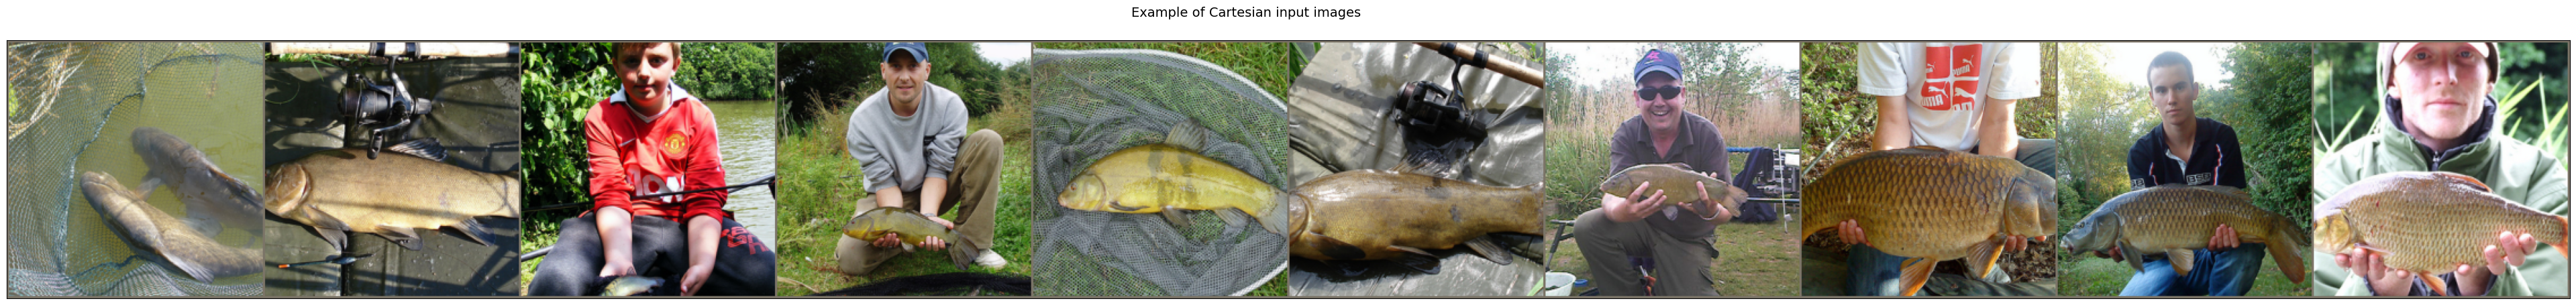

In [9]:
import matplotlib.pyplot as plt
fig, ax = imshow(images, title='Example of Cartesian input images', fig_height=5)
plt.show()


In [ ]:
args = fovea.Params(batch_size=N_show, do_mask=True)
val_loader, class_to_idx, idx_to_class = get_loader(args, VAL_DATA_DIR)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = imshow(images, title='Example of Cartesian input images', fig_height=5)
plt.show()


# testing each network on the validation dataset

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import json
import os
import requests


VAL_IMAGE_DIR = args.DATAROOT / 'Imagenet_full' / 'train'

# --- 3. Load the Pre-trained ResNet Model ---
# We'll use ResNet50, a powerful and common choice.
# `pretrained=True` downloads the model weights trained on ImageNet.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Move the model to the selected device (GPU or CPU)
model = model.to(args.device)

# Set the model to evaluation mode.
# This is crucial for disabling layers like Dropout and getting correct results from BatchNorm.
model.eval()



In [ ]:
extensions = ['*.jpeg', '*.jpg', '*.png', '*.JPEG', '*.JPG', '*.PNG']

image_files = []
for ext in extensions:
    # rglob returns a generator, so we extend the list with its results
    image_files.extend(VAL_IMAGE_DIR.rglob(ext))

print(f'In folder {VAL_IMAGE_DIR}, I found {len(image_files)} images')

In [ ]:
# --- 4. Download and Load the ImageNet Class Index ---
# The model outputs a class index (e.g., 281).
# We need a mapping from this index to a human-readable name (e.g., "tabby cat").
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
try:
    response = requests.get(LABELS_URL)
    response.raise_for_status()  # Raise an exception for bad status codes
    class_idx = response.json()
    # Create a simple mapping from index to class name for easy lookup
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
except requests.exceptions.RequestException as e:
    print(f"Error downloading labels: {e}")
    exit()



In [ ]:
# --- 5. Define Image Pre-processing ---
# The images must be pre-processed in the exact same way the model was trained on.
# This includes resizing, cropping, and normalizing.
preprocess = transforms.Compose([
    transforms.Resize(256),                # Resize the shortest side to 256px
    transforms.CenterCrop(224),            # Crop the center 224x224 pixels
    transforms.ToTensor(),                 # Convert the image to a PyTorch Tensor
    transforms.Normalize(                  # Normalize with ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:

print(f"\nStarting inference on images in '{VAL_IMAGE_DIR}'...")
print("-" * 50)

if not image_files:
    print("No image files found in the specified directory.")
else:
    for image_name in image_files:
        image_path = os.path.join(VAL_IMAGE_DIR, image_name)

        try:
            # Load the image
            img = Image.open(image_path).convert('RGB')

            # Pre-process the image and add a batch dimension
            # PyTorch models expect a batch of images, so we unsqueeze a dimension.
            img_t = preprocess(img)
            batch_t = torch.unsqueeze(img_t, 0).to(device)

            # Run inference
            # `torch.no_grad()` tells PyTorch not to compute gradients, saving memory and computation
            with torch.no_grad():
                output = model(batch_t)

            # --- Get the Prediction ---
            # The output is a tensor of logits. We find the index of the highest logit.
            # `torch.max` returns the max value and its index. We only need the index.
            _, index = torch.max(output, 1)
            
            # Move the result to CPU and convert it to a Python integer
            predicted_index = index[0].item()
            
            # Get the human-readable label from our mapping
            predicted_label = idx2label[predicted_index]

            # --- Print the result ---
            print(f"Image: {image_name:<30} | Predicted: {predicted_label}")

        except Exception as e:
            print(f"Could not process {image_name}: {e}")

    print("-" * 50)
    print("Inference complete.")



# testing each network for different rotations

In [ ]:
args = Params()
all_angles = np.linspace(-180, 180, 121) #, dtype=int)
data_set_types = ['raw', 'full', 'bbox']

In [ ]:
for data_set_type in data_set_types: 
    print(50*'=')
    print(f'{data_set_type=}')
    args = Params()
    args.angles = all_angles
    args.do_rotation = True
    args.do_mask = args.do_mask if data_set_type != 'raw' else False
    args.root  = f'{DATAROOT}/Imagenet_{data_set_type if data_set_type != 'raw' else 'full'}' # Directory containing images
    args.folders = ['val'] # type of images to use
    print(50*'-')
     
    for model_name in  ['resnet18', 'resnet50', 'resnet101'] :
        print(f'{model_name=}')

        for do_polar in [False, True]:
            do_polar = do_polar if data_set_type != 'raw' else False
            args.do_polar = do_polar
            print(f'{args.do_polar=}')
            print(50*'.')
            attack_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_attack_rotations.parquet'
            df_filename_acc = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_rotations_accuracy.parquet'
            if os.path.isfile(attack_filename):
                print(f'>> Reading {attack_filename=}')
                df_angle = pd.read_parquet(attack_filename)
            elif os.path.isfile(attack_filename + '.lock'):
                # we want to have a file but it's locked
                print(f'Path {attack_filename} is locked')
                df_angle = None                
            elif not os.path.isfile(attack_filename + '.lock'):
                # either we do not need a file or it does not exist (or it's locked)
                touch(attack_filename + '.lock') # we want to have a file let's lock it

                df_mean, df_attack = None, None
                print(f'>> Computing {df_filename_acc=}')

                image_dataset = image_datasets_transforms(args)['val']

                model_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '.pt' if data_set_type != 'raw' else None

                print(f"Loading pre-trained resnet {model_filename}")
                model = load_model(model_name=model_name, model_path=model_filename, do_circular=args.do_polar).to(device).eval()
            
                pprint(f'Testing : {model_name}')

                model = model.eval()
                
                with torch.no_grad():
                    acc_angles =  torch.zeros(len(args.angles))
                    for i_image, (data, label) in tqdm(enumerate(image_dataset)) : 
                        label_batch = (torch.ones([len(data)])*label).data
                        
                        data = data.to(device)
                
                        outputs = model(data)
                
                        outputs = torch.softmax(outputs, dim=1)
                
                        prior_outputs = outputs[:, label]
                        argmax = torch.argmax(prior_outputs) # best angle
                        argmin = torch.argmin(prior_outputs) # worst angle
                
                
                        _, preds = torch.max(outputs.data.cpu(), dim=1)
                        
                        df_attack_ = pd.DataFrame({'likelihood_0':[prior_outputs[len(args.angles)//2].item()], 
                                                   '0_pred':torch.argmax(outputs[len(args.angles)//2]).item(), 
                                                   'likelihood_max':prior_outputs[argmax].item(), 
                                                   'max_pos':args.angles[argmax.item()], 
                                                   'max_pred':torch.argmax(outputs[argmax]).item(), 
                                                   'likelihood_min':prior_outputs[argmin].item(), 
                                                   'min_pos':args.angles[argmin.item()], 
                                                   'min_pred':torch.argmax(outputs[argmin]).item(), 
                                                   'i_image':i_image, 'filename':image_dataset.imgs[i_image][0], 'label':label})
                        
                        df_attack = store_pandas(df_attack, df_attack_)
                
                    acc_angles /= len(image_dataset)
                    df_mean_ = pd.DataFrame({'mean_accuracy':[acc_angles.numpy()], 'var':[args.angles]})
                    df_mean = store_pandas(df_mean, df_mean_)
                    model.cpu()
                    df_mean.to_parquet(df_filename_acc)
                    df_attack.to_parquet(attack_filename)

                if os.path.isfile(attack_filename + '.lock'): os.remove(attack_filename + '.lock')


In [ ]:
args

In [ ]:
for model_name in  ['resnet18', 'resnet50', 'resnet101', ]:
    print(50*'=')
    print(f'{model_name=}')
    fig, ax = plt.subplots(figsize=(fig_width*phi/3, fig_width/phi/2))
    for data_set_type, ls in zip(['full', 'bbox', 'raw'], data_set_linestyles):
        print(f'{data_set_type=}')
        print(50*'-')

        for do_polar, color in zip([False, True], ['b', 'r']):

            if data_set_type == 'raw' :
                df_filename_acc = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_rotations_accuracy_smooth.parquet' if not do_polar else 'None'
                color = 'grey'
                lw = 3
                ls = '--'
            else:
                lw = 2
                df_filename_acc = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_rotations_accuracy_smooth.parquet'
            

            if os.path.isfile(df_filename_acc):
                df_angle = pd.read_parquet(df_filename_acc)

                results = [df_angle[df_angle['angle'] == angle]['match'].mean() for angle in np.hstack((df_angle['angle'].unique(), -180.))]
                label = 'Retinotopic mapping' if do_polar else 'Cartesian mapping'
                label += f' on {data_set_type} image' 
                ax.plot(np.hstack((df_angle['angle'].unique(), 180)), results, color=color, ls=ls, lw=lw, label=label)
        
    #ax.hlines(xmin=-185, xmax=185, y=1/2, ls='--', ec='gray')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlim(-180, 180)
    ax.set_ylim(0, 1)

    for angle in [-180, -90, 0, 90, 180]:
        ax.axvline(x=angle, c='k', ls='--', lw=1)
    ax.set_xticks([-180, -90, 0, 90, 180])
    #ax.set_yscale("logit", use_overline=True) #one_half="1/2", 
    #ax.set_yticks([.7, .75, .8])
    ax.set_ylabel('Average Accuracy', font=font)
    ax.set_xlabel('Rotation angle (°)', font=font)
    plt.legend(bbox_to_anchor=(0.8, 1), loc='best', fontsize=10, edgecolor='none')
    plt.tight_layout()
    # plt.xticks(font=font)
    # plt.yticks(font=font);
    plt.show()

In [ ]:
df_angle

# analysis: average accuracy for different rotations

In [ ]:
#Rotation attack read out
acc_plot = {}
for model_name in  ['resnet18', 'resnet50', 'resnet101']:

    print(50*'=')
    print(f'{model_name=}')
    for data_set_type, ls in zip(data_set_types, data_set_linestyles):
        print(f'{data_set_type=}')
        print(50*'-')

        for do_polar, color in zip([True, False], ['b', 'r']):

            df_filename_acc = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_attack_rotations.parquet'
            

            if os.path.isfile(df_filename_acc):

                df_angle = pd.read_parquet(df_filename_acc)
                print(do_polar)
                min = accuracy_score(df_angle['min_pred'], df_angle["label"])
                print(min, 'min')
                zero = accuracy_score(df_angle['0_pred'], df_angle["label"])
                print(zero, 'zero')
                max = accuracy_score(df_angle['max_pred'], df_angle["label"])
                print(max, 'max')
                print(zero-min, 'delta1', max-zero, 'delta2')

                acc_plot[get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_min'] = min

                acc_plot[get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_zero'] = zero

In [ ]:
df_angle

In [ ]:
fig_width = 15
fontsize = 18
font = font_manager.FontProperties(weight='normal', size=fontsize)
dpi = 'figure'
dpi = 200
opts_savefig = dict(dpi=dpi, bbox_inches='tight', pad_inches=0, edgecolor=None)

colors = ['b', 'r', 'k', 'g', 'm', 'y']
fig_width = 20
phi = (np.sqrt(5)+1)/2 # golden ratio for the figures :-)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(fig_width, fig_width/2.61803), width_ratios=[1, 1.8])

titles = ["(A) Rotation attack", "(B) Rotation invariance"]
model_name = 'resnet101'
#colors_cart = ['lightsteelblue', 'brown']
colors = ['royalblue', 'brown']

acc_full_lin = acc_plot[get_filename(data_cache, datetag, 'full', model_name, False) + '_zero']
acc_full_ret = acc_plot[get_filename(data_cache, datetag, 'full', model_name, True) + '_zero']
acc_bbox_lin = acc_plot[get_filename(data_cache, datetag, 'bbox', model_name, False) + '_zero']
acc_bbox_ret = acc_plot[get_filename(data_cache, datetag, 'bbox', model_name, True) + '_zero']

type_mod = ( "Cartesian", "Retinotopic")
data_means = {
    'full image': (acc_full_lin, acc_full_ret),
    'bounding box': (acc_bbox_lin, acc_bbox_ret ),

}

x = np.arange(len(type_mod))  # the label locations
width = 0.45  # the width of the bars
multiplier = 0
hatches = [None, "//"]

for i, (attribute, measurement) in enumerate(data_means.items()):
    offset = width * multiplier
    rects = axs[0].bar(x + offset, measurement, width, label=attribute, alpha =.5, color = colors, hatch=hatches[i])
    #axs[0].bar_label(rects, padding=2)
    multiplier += 1


acc_full_lin_min = acc_plot[get_filename(data_cache, datetag, 'full', model_name, False) + '_min']
acc_full_ret_min = acc_plot[get_filename(data_cache, datetag, 'full', model_name, True) + '_min']
acc_bbox_lin_min = acc_plot[get_filename(data_cache, datetag, 'bbox', model_name, False) + '_min']
acc_bbox_ret_min = acc_plot[get_filename(data_cache, datetag, 'bbox', model_name, True) + '_min']


data_means = {
    'full image': (acc_full_lin_min, acc_full_ret_min),
    'bounding box': (acc_bbox_lin_min, acc_bbox_ret_min )
}
multiplier = 0

for i, (attribute, measurement) in enumerate(data_means.items()):
    offset = width * multiplier
    rects = axs[0].bar(x + offset, measurement, width, color = colors, hatch=hatches[i])
    #axs[0].bar_label(rects, padding=2)
    multiplier += 1


axs[0].axhline(y=0.817, c='gray', ls='dotted', lw=3, label='before attack')
axs[0].axhline(y=0.461, c='gray', ls='--', lw=3, label='after attack')

axs[0].set_xticks(x + width/2, type_mod)
axs[0].set_ylabel('Accuracy', font=font)
axs[0].legend(loc='upper left', ncols=2, fontsize=15)
axs[0].set_ylim(0.2, 1)


for data_set_type, ls in zip(['full', 'bbox', 'raw'], data_set_linestyles):
    print(f'{data_set_type=}')
    for model_name in  ['resnet101']:
        print(50*'=')
        print(f'{model_name=}')

        print(50*'-')

        for do_polar, color in zip([False, True],  ['royalblue', 'brown', 'gray']):

            if data_set_type == 'raw' :
                df_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_rotations_accuracy_smooth.parquet' if not do_polar else 'None'
                color = 'grey'
                lw = 3
                ls = '--'
            else:
                lw = 2
                df_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_rotations_accuracy_smooth.parquet'

            if os.path.isfile(df_filename):
               # data_set_type = 'full image' if 'full' in data_set_type else 'bounding box'
                
                df_angle = pd.read_parquet(df_filename)

                results = [df_angle[df_angle['angle'] == angle]['match'].mean() for angle in np.hstack((df_angle['angle'].unique(), -180.))]
                label = 'Retinotopic coordinates' if do_polar else 'Cartesian coordinates'
                label += f' on {data_set_type} image' if data_set_type != 'raw' else f' without fine tuning'
                axs[1].plot(np.hstack((df_angle['angle'].unique(), 180)), results, color=color, ls=ls, lw=5, label=label)
        

ax = axs[1]
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_xlim(-180, 180)


for angle in [-180, -90, 0, 90, 180]:
    ax.axvline(x=angle, c='k', ls='--', lw=1)
ax.set_xticks([-180, -90, 0, 90, 180])
#ax.set_yscale("logit", use_overline=True) #one_half="1/2", 
#ax.set_yticks([.7, .75, .8])
#ax.set_ylabel('Average Accuracy', font=font)
ax.set_xlabel('Rotation angle (°)', font=font)
plt.legend(loc='lower center', fontsize=fontsize, edgecolor='none')
plt.tight_layout()
# plt.xticks(font=font)
# plt.yticks(font=font);


# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
for j, ax in enumerate(axs):
        ax.set_title(titles[j], font=font)
        ax.tick_params(axis='both', labelsize=fontsize)    
        #for i, container in enumerate(ax.containers):
        #    ax.bar_label(container, padding=-15, color='black', fmt='%.3f', rotation=0, label_type = 'edge', fontsize=fontsize, weight='bold')

plt.xticks(font=font)
plt.yticks(font=font)
plt.tight_layout()

In [ ]:
to_save(fig, name='fig-rotation')

In [ ]:
# fig, ax = plt.subplots(figsize=(fig_width*phi/3, fig_width/phi/2))
# for data_set_type, ls in zip(['bbox'], data_set_linestyles):
#     print(f'{data_set_type=}')
#     for model_name in  ['resnet101']:
#         print(50*'=')
#         print(f'{model_name=}')

#         print(50*'-')

#         for do_polar, color in zip([False, True],  ['royalblue', 'brown']):

#             df_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_test-rotations.json'

#             if os.path.isfile(df_filename):
#                # data_set_type = 'full image' if 'full' in data_set_type else 'bounding box'
                
#                 df_angle = pd.read_json(df_filename)

#                 results = [df_angle[df_angle['angle'] == angle]['match'].mean() for angle in np.hstack((df_angle['angle'].unique(), -180.))]
#                 label = 'Retinotopic coordinates' if do_polar else 'Cartesian coordinates'
#                 label += f' on {data_set_type} image' 
#                 ax.plot(np.hstack((df_angle['angle'].unique(), 180)), results, color=color, ls='--', lw=5)

# ax.tick_params(axis='x', labelsize=fontsize)
# ax.tick_params(axis='y', labelsize=fontsize)
# ax.set_xlim(-180, 180)


# for angle in [-180, -90, 0, 90, 180]:
#     ax.axvline(x=angle, c='k', ls='--', lw=1)
# ax.set_xticks([-180, -90, 0, 90, 180])
# #ax.set_yscale("logit", use_overline=True) #one_half="1/2", 
# #ax.set_yticks([.7, .75, .8])
# #ax.set_ylabel('Average Accuracy', font=font)
# ax.set_xlabel('Rotation angle (°)', font=font)
# plt.legend(loc='lower center', fontsize=fontsize, edgecolor='none')
# plt.tight_layout()
# ax.set_ylim(0, 1)
# #ax.set_xticks(x + width/2, type_mod)
# ax.set_ylabel('Accuracy', font=font)
# # plt.xticks(font=font)
# # plt.yticks(font=font);

In [ ]:
# Old script from LuP with smooth curves
args = Params()
args.angles = np.linspace(-180, 180, 121) #, dtype=int)

angle_temp = args.angles
delta_angle = angle_temp[1] - angle_temp[0]
angles_minus = angle_temp - delta_angle/2
angles_plus = angle_temp + delta_angle/2

# Loading and testing the networks
for data_set_type in ['raw', 'full', 'bbox']:
    print(50*'=')
    print(f'{data_set_type=}', end=', ')
    args = Params()
    #args.do_rotation = True
    args.do_mask = args.do_mask if data_set_type != 'raw' else False
    args.do_rot_train = True
    args.root  = f'{DATAROOT}/Imagenet_{data_set_type if data_set_type != 'raw' else 'full'}' # Directory containing images
    args.folders = ['val'] # type of images to use
    print(50*'-')
        
    for model_name in  ['resnet18', 'resnet50', 'resnet101']: 
        print(f'{model_name=}')

        for do_polar in [True, False]:
            do_polar = do_polar if data_set_type != 'raw' else False
            args.do_polar = do_polar
            print(f'{args.do_polar=}')
            print(50*'.')
            df_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '_results_rotations_accuracy_smooth.parquet'
            if os.path.isfile(df_filename):
                print(f'>>Reading {df_filename=}')
                df_angle = pd.read_parquet(df_filename)
            elif os.path.isfile(df_filename + '.lock'):
                # we want to have a file but it's locked
                print(f'Path {df_filename} is locked')
            elif not os.path.isfile(df_filename + '.lock'):               
                # either we do not need a file or it does not exist (or it's locked)
                touch(df_filename + '.lock') # we want to have a file let's lock it
                print(f'>>Computing {df_filename=}')
                print(50*'-')
                results = np.zeros((0, 3))
                #model_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '.pt'
                model_filename = get_filename(data_cache, datetag, data_set_type, model_name, do_polar) + '.pt' if data_set_type != 'raw' else None

                #if os.path.isfile(model_filename):
                print(f"Loading pre-trained resnet {model_filename}")
                model = load_model(model_name=model_name, model_path=model_filename, do_circular=args.do_polar).to(device).eval()

                for angle, angle_minus, angle_plus in zip(angle_temp, angles_minus, angles_plus):
                    print(f'{angle=}', end='')
                    args.angles = [angle_minus, angle_plus]
                    dataloaders = datasets_transforms(args, shuffle=False, verbose=False)
                    
                    with torch.no_grad():
                        for i_image, (images, labels) in enumerate(dataloaders['val']):
                            images, labels = images.to(device), labels.to(device)

                            outputs = model(images)

                            _, preds = torch.max(outputs.data, dim=1)
                            detect = (preds == labels.data).cpu().numpy()

                            results_ = np.vstack([i_image*args.batch_size_val + np.arange(len(detect)), angle*np.ones(len(detect)), detect]).T
                            results = np.vstack((results, results_))

                    print(f', Accuracy={detect.mean():.3f}')
                df_angle = pd.DataFrame(results, columns=['i_image', 'angle', 'match'])     
                df_angle.to_parquet(df_filename)                        
                print(25*'. ')
            if os.path.isfile(df_filename + '.lock'): os.remove(df_filename + '.lock')

    print(50*'=')